# SNF example

In this example script we will go through the different steps to carry out the similarity network fusion analysis. Steps

1. Calculate the distance matrix for metabolites (Euclidean distance) and SNPs (Chi2 distance)
2. Generate the affinity matrix out of the distance matrices
3. Apply the SNF iterative process

In [1]:
#### Packages
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler #For scaling cont data
from sklearn.metrics.pairwise import additive_chi2_kernel
from sklearn.metrics.pairwise import chi2_kernel
from scipy.stats import chisquare

In [2]:
os.chdir('..')
mainpath = os.getcwd()
datapath = os.path.join(mainpath, 'Data')

In [3]:
os.chdir(datapath)
dat = pd.read_csv('MFA_data.txt', sep = '\t')
dat

,snp1,snp2,snp3,snp4,snp5,snp6,status,Met1,Met2,Met3,Met4,Met5,Met6,Met7
1,AG,GG,GG,GG,AG,GG,control,19.115735,24.799236,27.515510,18.720287,17.537699,7.985089,17.269974
2,GG,GG,AA,AG,AA,AA,control,17.881166,33.280194,23.602213,18.634412,26.336851,14.980349,26.566395
3,AG,AG,GG,AA,AA,GG,control,14.636506,21.469032,8.892394,34.586894,25.074224,25.075590,17.695359
4,AG,AA,AA,AA,AG,AA,control,20.859077,18.653941,13.926668,13.942551,14.533406,21.602728,18.705230
5,AA,GG,AA,AG,GG,GG,control,21.478823,22.533771,13.945255,26.942080,11.095887,22.379987,14.133174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,AA,GG,GG,GG,GG,GG,case,84.011725,90.826447,86.695616,36.224281,42.547626,12.277822,12.551261
97,AA,AG,AA,AA,AA,GG,case,76.668232,56.594193,88.638639,25.510741,22.413257,18.222310,11.231814
98,AA,AG,AA,AG,GG,AG,case,47.265209,123.766174,88.009429,32.042963,32.030187,23.894796,26.152011
99,AG,GG,GG,AA,AG,GG,case,30.064596,114.765895,103.711147,25.848189,13.926033,29.525660,18.156616


In [4]:
#### Divide in snp, status, and met datasets
snp = dat.iloc[:, 0:6]
met = np.array(dat.iloc[:, 7:])
status = dat.iloc[:, 6]

# Create a numeric snp data
snp_num = snp.copy()
snp_num[snp_num=='AA'] = 0
snp_num[snp_num=='AG'] = 1
snp_num[snp_num=='GG'] = 2

# Distance matrices

In [5]:
#### For the metabolite data, we will use the Euclidean distance
# First, let's scale the data
scaler = StandardScaler()
scaler.fit(met)
met = scaler.transform(met)

In [6]:
#Initialize an empty 100 x 100 distance matrix
met_dist = np.zeros((100,100))

#Calculate pairwise Euclidean distances
for i in range(0,len(met_dist)):
    n = i + 1
    for j in range(n,len(met_dist)):
        p1 = met[i,:]
        p2 = met[j,:]
        dist = np.linalg.norm(p1 - p2)
        met_dist[i,j] = dist
        met_dist[j,i] = dist

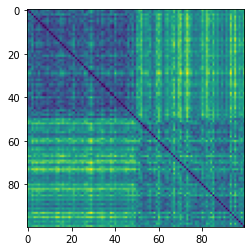

In [11]:
fig, ax = plt.subplots()
im = ax.imshow(met_dist)
plt.show()

For the SNP data, we will use the Chi-square distance as recommended by the original paper. The formula was taken from [here](https://www.lives-nccr.ch/sites/default/files/pdf/publication/33_lives_wp_studer_sequencedissmeasures.pdf)

In [12]:
#### For the SNP data, we will use the Chi-square distance as recommended by the original paper
def chi2distance(x,y):
    '''
    Function to calculate the chi 2 distance between state distributions in x and y vectors
    '''
    nrows = len(x)
    
    paa = ( (x == 'AA').sum() + (y == 'AA').sum() ) / (nrows*2)
    pag = ( (x == 'AG').sum() + (y == 'AG').sum() ) / (nrows*2)
    pgg = ( (x == 'GG').sum() + (y == 'GG').sum() ) / (nrows*2)
    
    paax = (x == 'AA').sum() / nrows
    pggx = (x == 'GG').sum() / nrows
    pagx = (x == 'AG').sum() / nrows

    paay = (y == 'AA').sum() / nrows
    pggy = (y == 'GG').sum() / nrows
    pagy = (y == 'AG').sum() / nrows
    
    if paa == 0:
        term1 = 0
    else:
        term1 = ( ( (paax - paay) ** 2 ) / paa )
        
    if pag == 0:
        term2 = 0 
    else:
        term2 = ( ( (pagx - pagy) ** 2 ) / pag )
        
    if pgg == 0:
        term3 = 0 
    else:
        term3 = ( ( (pggx - pggy) ** 2 ) / pgg  )
        
    d = term1 + term2 + term3
    
    return(d)

In [14]:
#### Calculate chi 2 distance matrix

#Initialize an empty 100 x 100 distance matrix
snp_dist = np.zeros((100,100))

#Calculate pairwise chi 2 distances
for i in range(0,len(snp_dist)):
    n = i + 1
    for j in range(n,len(snp_dist)):
        x = snp.iloc[i,:]
        y = snp.iloc[j,:]
        dist = chi2distance(x, y)
        snp_dist[i,j] = dist
        snp_dist[j,i] = dist

array([[0.        , 1.33333333, 0.88888889, ..., 1.33333333, 0.38095238,
        0.82539683],
       [1.33333333, 0.        , 0.17777778, ..., 0.51111111, 0.51111111,
        0.13333333],
       [0.88888889, 0.17777778, 0.        , ..., 0.17777778, 0.17777778,
        0.17777778],
       ...,
       [1.33333333, 0.51111111, 0.17777778, ..., 0.        , 0.51111111,
        0.66666667],
       [0.38095238, 0.51111111, 0.17777778, ..., 0.51111111, 0.        ,
        0.22222222],
       [0.82539683, 0.13333333, 0.17777778, ..., 0.66666667, 0.22222222,
        0.        ]])

In [15]:
pd.DataFrame(snp_dist)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,1.333333,0.888889,2.666667,0.825397,2.933333,1.333333,1.714286,1.600000,0.380952,...,0.825397,1.037037,0.444444,2.044444,2.044444,1.037037,2.044444,1.333333,0.380952,0.825397
1,1.333333,0.000000,0.177778,0.825397,0.133333,0.611111,0.000000,0.400000,0.222222,0.511111,...,0.133333,1.095238,0.555556,0.158730,0.158730,1.095238,0.158730,0.511111,0.511111,0.133333
2,0.888889,0.177778,0.000000,0.888889,0.177778,1.206349,0.177778,0.800000,0.177778,0.177778,...,0.177778,1.206349,0.444444,0.444444,0.444444,1.206349,0.444444,0.177778,0.177778,0.177778
3,2.666667,0.825397,0.888889,0.000000,1.333333,1.037037,0.825397,1.714286,0.380952,1.600000,...,1.333333,2.933333,2.044444,0.444444,0.444444,2.933333,0.444444,0.622222,1.600000,1.333333
4,0.825397,0.133333,0.177778,1.333333,0.000000,1.095238,0.133333,0.400000,0.511111,0.222222,...,0.000000,0.611111,0.158730,0.555556,0.555556,0.611111,0.555556,0.666667,0.222222,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.037037,1.095238,1.206349,2.933333,0.611111,1.777778,1.095238,0.500000,1.888889,0.833333,...,0.611111,0.000000,0.370370,1.822222,1.822222,0.000000,1.822222,2.000000,0.833333,0.611111
96,2.044444,0.158730,0.444444,0.444444,0.555556,0.370370,0.158730,0.714286,0.158730,1.044444,...,0.555556,1.822222,1.200000,0.000000,0.000000,1.822222,0.000000,0.555556,1.044444,0.555556
97,1.333333,0.511111,0.177778,0.622222,0.666667,1.428571,0.511111,1.400000,0.133333,0.511111,...,0.666667,2.000000,1.044444,0.555556,0.555556,2.000000,0.555556,0.000000,0.511111,0.666667
98,0.380952,0.511111,0.177778,1.600000,0.222222,1.888889,0.511111,1.000000,0.666667,0.000000,...,0.222222,0.833333,0.158730,1.044444,1.044444,0.833333,1.044444,0.511111,0.000000,0.222222


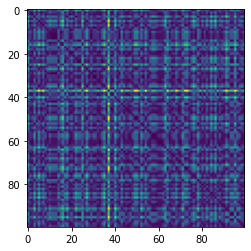

In [10]:
fig, ax = plt.subplots()
im = ax.imshow(snp_dist)
plt.show()

In [13]:
def affinity_matrix(mat, K, eps):
    Machine_Epsilon = np.finfo(float).eps
    Diff_mat = (mat + mat.transpose()) / 2 
    Diff_mat_sort = Diff_mat - np.diag(np.diag(Diff_mat))
    Diff_mat_sort = np.sort(Diff_mat_sort, axis=0)
    
    K_dist = np.mean(Diff_mat_sort[:K], axis=0)
    epsilon = (K_dist + K_dist.transpose()) / 3 * 2 + Diff_mat / 3 + Machine_Epsilon
    
    W = np.exp(-(Diff_mat / (eps * epsilon)))
    
    return((W + W.transpose() )/ 2)


In [14]:
W1 = affinity_matrix(met_dist, 20, 0.5)
W2 = affinity_matrix(snp_dist, 20, 0.5)

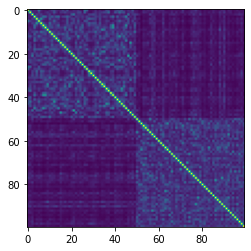

In [15]:
fig, ax = plt.subplots()
im = ax.imshow(W1)
plt.show()

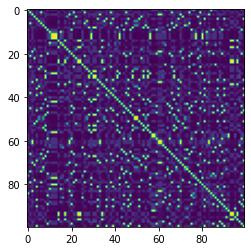

In [16]:
fig, ax = plt.subplots()
im = ax.imshow(W2)
plt.show()

# SNF main functions

In [18]:
def full_kernel(W):
    '''
    Calculate full kernel matrix normalization
    '''
    
    rowsum = W.sum(axis=1) - W.diagonal()
    rowsum[rowsum == 0] = 1
    P = W / (2*rowsum)
    
    np.fill_diagonal(P, 0.5)
    return(P)

In [19]:
def sparse_kernel(W, k):
    '''
    Calculate sparse kernel matrix using the k nearest neighbors
    '''
    nrow = len(W)
    S    = np.zeros((nrow,nrow))
    for i in range(0,nrow):
        s1 = W[i,:].copy()
        ix = s1.argsort()
        s1[ix[0:(nrow-k)]] = 0
        S[i,] = s1
        
    S = full_kernel(S)
    return(S)
    

In [20]:
def SNF(Ws, k=20, t=20):
    '''
    Similarity network fusion for t iterations
    '''
    nw = len(Ws)
    Ps = []
    Ss = []
    
    for i in range(0,nw):
        Ps.append(full_kernel(Ws[i])) 
        Ps[i] = ( Ps[i] + Ps[i].transpose() ) / 2 
        Ss.append(sparse_kernel(Ps[i], k))
    
    #Generate to Ps that will be updated
    Pst0 = Ps.copy()
    Pst1 = Ps.copy()
    
    #Iteration process
    for i in range(0,t):
        for j in range(0,nw):
            if j == 0:
                m = 1
            elif j == 1:
                m = 0
            Pst1[j] = np.matmul( np.matmul(Ss[j], Pst0[m]), Ss[j].transpose()) 
            Pst1[j] = full_kernel(Pst1[j])
        #Update the zero state
        Pst0 = Pst1.copy()
    
    Pc = (Pst1[0] + Pst1[1]) / 2
    return(Pc)
            

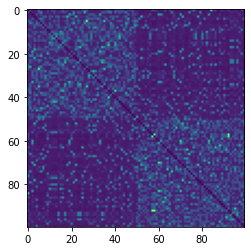

In [21]:
Pc = SNF([W1,W2])
np.fill_diagonal(Pc, 0)
fig, ax = plt.subplots()
im = ax.imshow(Pc)
plt.show()